In [50]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import Net 
from misc import imutils
import matplotlib.pyplot as plt
from torch import nn
from net import resnet50

In [51]:
class CAM(nn.Module):
    def __init__(self):
        super(CAM, self).__init__()
        self.resnet50 = resnet50.resnet50(
            pretrained=True, strides=(2, 2, 2, 1))

        self.stage1 = nn.Sequential(self.resnet50.conv1, self.resnet50.bn1, self.resnet50.relu, self.resnet50.maxpool,
                                    self.resnet50.layer1)
        self.stage2 = nn.Sequential(self.resnet50.layer2)
        self.stage3 = nn.Sequential(self.resnet50.layer3)
        self.stage4 = nn.Sequential(self.resnet50.layer4)

        self.classifier = nn.Conv2d(2048, 20, 1, bias=False)

        self.backbone = nn.ModuleList(
            [self.stage1, self.stage2, self.stage3, self.stage4])
        self.newly_added = nn.ModuleList([self.classifier])

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = F.conv2d(x, self.classifier.weight)
        x = F.relu(x)
        x = x[0]
        return x

    def train(self, mode=True):
        for p in self.resnet50.conv1.parameters():
            p.requires_grad = False
        for p in self.resnet50.bn1.parameters():
            p.requires_grad = False

    def trainable_parameters(self):
        return (list(self.backbone.parameters()), list(self.newly_added.parameters()))

In [52]:
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_cam.pth'
frontdoor_cam_weight_path = '/Users/Andy/Projects/resnet50_c2am.pth'

model_baseline = CAM()
model_frontdoor = CAM()
model_baseline.eval()
model_frontdoor.eval()
model_baseline.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))
model_frontdoor.load_state_dict(torch.load(frontdoor_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [4]:
train_list = '/Users/Andy/Projects/c2am/voc12/train.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
train_loader = DataLoader(train_dataset, shuffle=False)

val_list = '/Users/Andy/Projects/c2am/voc12/val.txt'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
val_loader = DataLoader(val_dataset, shuffle=False)

In [5]:
for pack in train_loader:
    name = pack['name'][0]
    # print(name)
    if name == '2008_004430':
        print(pack['label'][0])
        break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])


In [6]:
with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    print(img_name)

    strided_up_size = imutils.get_strided_up_size(size, 16)

    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]

    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5

2008_004430


/Users/Andy/Projects/c2am/misc/imutils.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


2008_004430


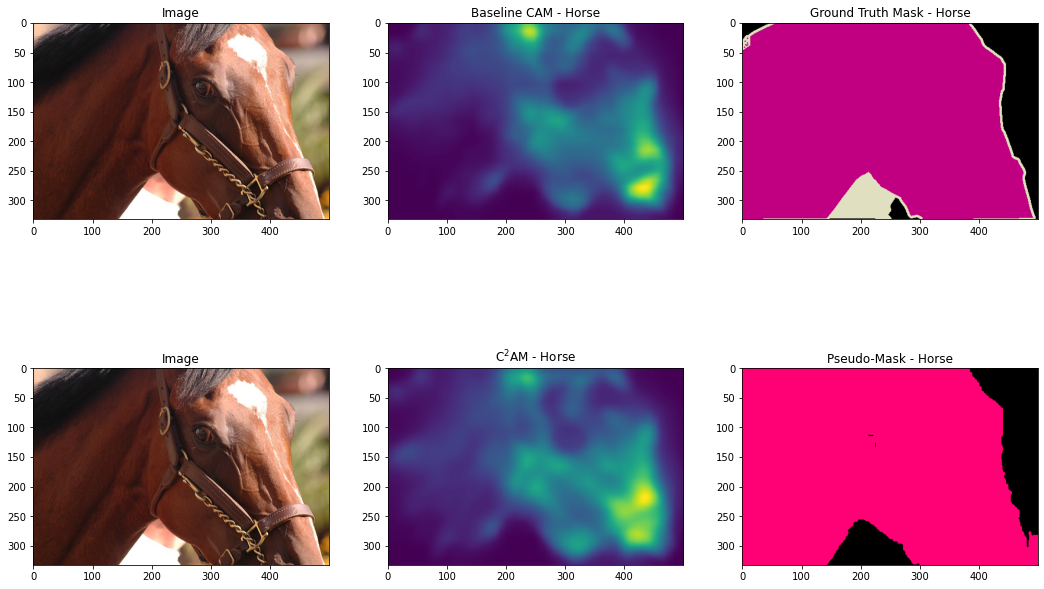

In [12]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
pseudo_color = imutils.colorize_label(np.asarray(pseudo))
gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Horse')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax2 = fig.add_subplot(333)
plt.title('Ground Truth Mask - Horse')
ax2.imshow(gt)
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('C$^2$AM - Horse')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax2 = fig.add_subplot(336)
plt.title('Pseudo-Mask - Horse')
ax2.imshow(pseudo_color)

In [6]:
data_iter = iter(train_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    print(img_name)

    strided_up_size = imutils.get_strided_up_size(size, 16)

    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]

    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5

2007_000068


/Users/Andy/Projects/c2am/misc/imutils.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([375, 500, 3])
[  0   3 255]
[0 3]
2007_000068


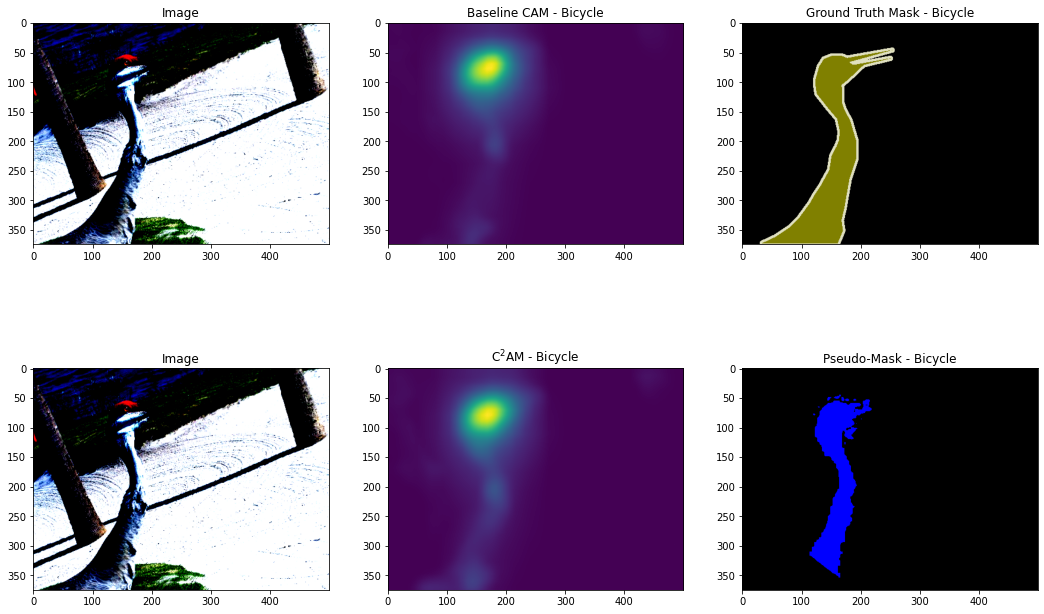

In [11]:
im = pack['img'][0][0][0].permute(1, 2, 0)
print(im.shape)
pseudo = Image.open(os.path.join(voc12_root, 'SegmentationClassAug', img_name + '.png'))
pseudo_color = imutils.colorize_label(np.asarray(pseudo))
gt = Image.open(os.path.join(voc12_root, 'SegmentationClass', img_name + '.png'))

print(np.unique(np.asarray(gt)))
print(np.unique(np.asarray(pseudo)))

print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Bicycle')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax2 = fig.add_subplot(333)
plt.title('Ground Truth Mask - Bicycle')
ax2.imshow(gt)
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('C$^2$AM - Bicycle')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax2 = fig.add_subplot(336)
plt.title('Pseudo-Mask - Bicycle')
ax2.imshow(pseudo_color)

In [65]:
import torchvision
rcrop = torchvision.transforms.RandomResizedCrop((375, 500))

data_iter = iter(train_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

c2ams = []
images = []
for i in range(5):
    with torch.no_grad():
        img_name = pack['name'][0]
        imgs = pack['img']
        label = pack['label'][0]
        size = pack['size']
        print(pack['img'][0].shape)
        
        if i != 0:
            imgs = [rcrop(pack['img'][0][0][0]).unsqueeze(0).unsqueeze(0)]
            
        images += [imgs[0].squeeze()]

        strided_up_size = imutils.get_strided_up_size(size, 16)

        frontdoor_outputs = [model_frontdoor(img[0]) for img in imgs]
        frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                    o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
        frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                    :, 0, :size[0], :size[1]]
        valid_cat = torch.nonzero(label)[:, 0]
        frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
        frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5
        c2ams += [frontdoor_highres_cam]

torch.Size([1, 2, 3, 375, 500])
torch.Size([1, 2, 3, 375, 500])
torch.Size([1, 2, 3, 375, 500])
torch.Size([1, 2, 3, 375, 500])
torch.Size([1, 2, 3, 375, 500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 375, 500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


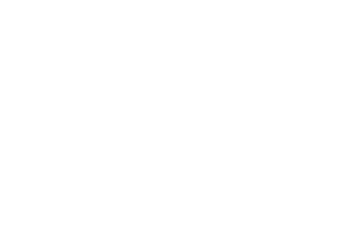

<Figure size 1296x1296 with 0 Axes>

In [77]:
print(images[0].shape)

plt.rcParams.update({"text.usetex": True})
plt.axis('off')

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(251)
ax.imshow(images[0][0].permute(1, 2, 0))
save(images[0][0].permute(1, 2, 0), name='img0', title='Image')


ax = fig.add_subplot(252)
ax.imshow(images[1].permute(1, 2, 0))
save(images[1].permute(1, 2, 0), name='img1', title='Image')

ax = fig.add_subplot(253)
ax.imshow(images[2].permute(1, 2, 0))
save(images[2].permute(1, 2, 0), name='img2', title='Image')


ax = fig.add_subplot(254)
ax.imshow(images[3].permute(1, 2, 0))
save(images[3].permute(1, 2, 0), name='img3', title='Image')

ax = fig.add_subplot(255)
ax.imshow(images[4].permute(1, 2, 0))
save(images[4].permute(1, 2, 0), name='img4', title='Image')


ax = fig.add_subplot(256)
ax.imshow(c2ams[0].squeeze())
save(c2ams[0].squeeze(), name='c2am0', title='C$$^2$$AM')


ax = fig.add_subplot(257)
ax.imshow(c2ams[1].squeeze())
save(c2ams[1].squeeze(), name='c2am1', title='C$$^2$$AM')

ax = fig.add_subplot(258)
ax.imshow(c2ams[2].squeeze())
save(c2ams[2].squeeze(), name='c2am2', title='C$$^2$$AM')

ax = fig.add_subplot(259)
ax.imshow(c2ams[3].squeeze())
save(c2ams[3].squeeze(), name='c2am3', title='C$$^2$$AM')

ax = fig.add_subplot(2,5,10)
ax.imshow(c2ams[4].squeeze())
save(c2ams[4].squeeze(), name='c2am4', title='C$$^2$$AM')

In [76]:
def save(img, name='img', title='Image'):
    plt.imshow(img)
    plt.axis('off')
    plt.savefig('{}.pdf'.format(name), bbox_inches='tight', pad_inches=0)
    plt.clf()